In [1]:
import os
import pandas as pd
import shutil, os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.backend import clear_session
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam

In [3]:
# Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Prevent GPU memory overflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
#import multiprocessing
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.1
EPOCHS = 10
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
NFOLDS = 5 # No of folds for cross validation
WORKERS = 4 #multiprocessing.cpu_count()-1 #32 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [5]:
# DF_PATH = '/homes/pp837/train-jpg'
# DF_CSV_PATH = '/homes/pp837/train_v2.csv'
# df = pd.read_csv(DF_CSV_PATH)
# df['image_name'] = df['image_name'].astype(str) + '.jpg'
# #print(df.head())
# train, test = train_test_split(df, test_size=0.2, random_state=1)
# print(train.head())
# print("*****")
# print(test.head())

In [6]:
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + '/train_file/train_label.csv'
TEST_CSV_PATH = DATASET_PATH + '/test_file/test_label.csv'

In [7]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print()
print(df_test.head())

        image_name                 tags
0   train_3577.jpg         haze primary
1  train_10327.jpg        clear primary
2   train_1243.jpg  clear primary water
3  train_17066.jpg        clear primary
4  train_15959.jpg        clear primary

       image_name                                        tags
0  test_32752.jpg                            [clear, primary]
1   test_7767.jpg                            [clear, primary]
2   test_4254.jpg  [agriculture, clear, cultivation, primary]
3  test_23119.jpg                            [clear, primary]
4  test_22101.jpg               [agriculture, clear, primary]


In [8]:
X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist())

In [9]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [10]:
# plt.figure(figsize=(20, 20))
# res = [32, 64, 128, 256]
# NIMGS = 5
# train = df_train.reset_index()
# test = df_test.reset_index()

# for i in range(len(res)):
#     for j in range(NIMGS):
#         img = cv2.imread(os.path.join(TRAIN_PATH, df_train['image_name'][j+1]))
#         img = cv2.resize(img, (res[i], res[i]))
#         plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]))
#         plt.axis('off')
    
# plt.show()

blow_down is tagged least no of times: 74
primary is tagged max no of times: 29978


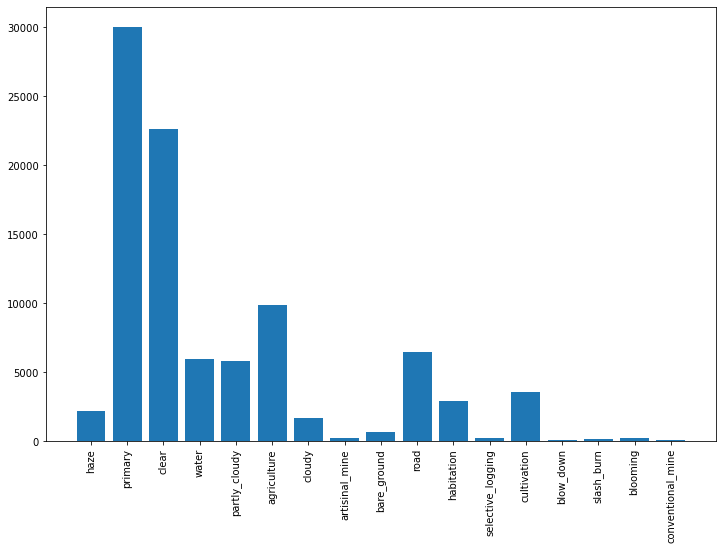

In [11]:
#Distribution of the labels :

plt.figure(figsize=(12, 8))

labels_count = {}

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 0
            
min_label = min(labels_count, key=labels_count.get)
max_label = max(labels_count, key=labels_count.get)

print(min_label+" is tagged least no of times: "+str(labels_count[min_label]))
print(max_label+" is tagged max no of times: "+str(labels_count[max_label]))
            
plt.bar(range(len(labels_count)), list(labels_count.values()), align='center')
plt.xticks(range(len(labels_count)), list(labels_count.keys()), rotation=90)

plt.show()

In [12]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta_squared = 4
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [13]:
#Define CNN model architecture:

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Flatten(),

#         Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])

    #optimizer = Adam(0.001, decay=0.0001)

    return model

model = create_model()

clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [16]:
#Run the model  with k-fold cross validation:

y_test = []
fold = {}

folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=1).split(X_train_files, y_train)
num_fold = 0
for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))
#     print(train_df.head(5))
#     print("************")
#     print(val_df.head(5))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        #validate_filenames=False,
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    #print("train gen complete")
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        #validate_filenames=False,
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        #validate_filenames=False,
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
    )

    model_path_of_fold = ROOT_PATH + '/' + 'weights_of_fold_' + str(num_fold) + '.h5'
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=LR)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='fbeta_score_K', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                       workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    print(history.history.keys())
    
    fold[num_fold] = {}
    for key, value in history.history.items():
        fold[num_fold][key] = value 
        
    #  "Accuracy"
#     plt.plot(history.history['fbeta_score_K'])
#     plt.plot(history.history['val_fbeta_score_K'])
#     plt.title('model accuracy')
#     plt.ylabel('fbeta_score_K')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()
#     # "Loss"
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()

    model.load_weights(model_path_of_fold)

    p_test = model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
    y_test.append(p_test)
    num_fold+=1
    #break;

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/10
203/203 [==============================] - 61s 264ms/step - loss: 0.3729 - fbeta_score_K: 0.4875 - val_loss: 0.2360 - val_fbeta_score_K: 0.5788
Epoch 2/10
203/203 [==============================] - 53s 256ms/step - loss: 0.2277 - fbeta_score_K: 0.5925 - val_loss: 0.2149 - val_fbeta_score_K: 0.6147
Epoch 3/10
203/203 [==============================] - 51s 249ms/step - loss: 0.2121 - fbeta_score_K: 0.6229 - val_loss: 0.2020 - val_fbeta_score_K: 0.6360
Epoch 4/10
203/203 [==============================] - 52s 251ms/step - loss: 0.2043 - fbeta_score_K: 0.6393 - val_loss: 0.1980 - val_fbeta_score_K: 0.6338
Epoch 5/10
203/203 [==============================] - 51s 248ms/step - loss: 0.1946 - fbeta_score_K: 0.6535 - val_loss: 0.1903 - val_fbeta_score_K: 0.6464
Epoch 6/10
203/203 [==================

In [17]:
#fold

In [18]:
loss = np.zeros(EPOCHS,dtype=float)
val_loss = np.zeros(EPOCHS,dtype=float)
fbeta_score_K = np.zeros(EPOCHS,dtype=float)
val_fbeta_score_K = np.zeros(EPOCHS,dtype=float)

for key,val in fold.items():
    loss += np.array(fold[key]['loss'])
    val_loss += np.array(fold[key]['val_loss'])
    fbeta_score_K += np.array(fold[key]['fbeta_score_K'])
    val_fbeta_score_K += np.array(fold[key]['val_fbeta_score_K'])
print(loss)
print(val_loss)
print(fbeta_score_K)
print(val_fbeta_score_K)

[1.43064883 1.11678997 1.05567138 1.01178087 0.96922019 0.91866772
 0.87192498 0.83893095 0.81909153 0.79753898]
[1.19690682 1.10220432 1.02879632 0.98843725 0.93923277 0.88540795
 0.84877296 0.81124204 0.7929287  0.77613102]
[2.69319195 3.00491124 3.130795   3.21156734 3.28867376 3.38696474
 3.4832446  3.54754055 3.58722359 3.62584645]
[2.86247337 2.99724585 3.14103645 3.20906514 3.30183274 3.46806228
 3.54092336 3.57874894 3.6257875  3.66963685]


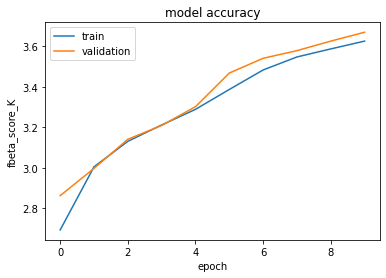

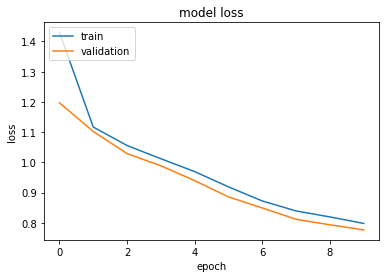

In [19]:
plt.plot(fbeta_score_K)
plt.plot(val_fbeta_score_K)
plt.title('model accuracy')
plt.ylabel('fbeta_score_K')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

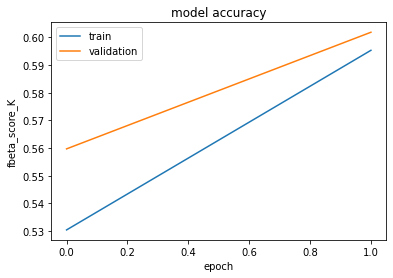

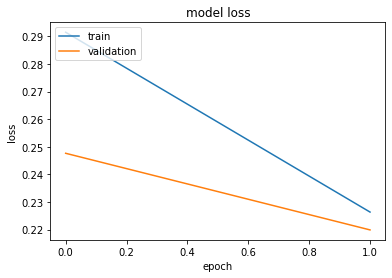

In [45]:
#    "Accuracy"
plt.plot(fold[0]['fbeta_score_K'])
plt.plot(fold[0]['val_fbeta_score_K'])
plt.title('model accuracy')
plt.ylabel('fbeta_score_K')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#   "Loss"
plt.plot(fold[0]['loss'])
plt.plot(fold[0]['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
# Average the k results obtained from k-fold cross validation

result = np.array(y_test[0])
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.019460,0.000131,0.000755,0.005989,0.000674,0.989659,0.000025,0.000042,0.017177,0.001912,0.000312,0.009429,0.999912,0.009211,0.002090,0.000383,0.026468
1,0.027081,0.000171,0.001551,0.004225,0.000654,0.983814,0.000101,0.000078,0.023087,0.003040,0.001692,0.012793,0.999554,0.011696,0.001645,0.000594,0.039285
2,0.711673,0.002720,0.016508,0.004473,0.003284,0.945451,0.000003,0.000385,0.488736,0.097990,0.001404,0.060213,0.999962,0.197369,0.015966,0.009725,0.225811
3,0.017694,0.000105,0.000705,0.005127,0.000559,0.990602,0.000024,0.000037,0.015979,0.001729,0.000298,0.008446,0.999912,0.008349,0.001710,0.000334,0.025153
4,0.659183,0.014183,0.238508,0.000097,0.000692,0.940656,0.000583,0.037273,0.077468,0.452686,0.017210,0.049351,0.794637,0.694695,0.001039,0.001663,0.225632


In [27]:
#Pickling the result_new df
import pickle
FilePath = ROOT_PATH + '/' + 'result_mb_25.pickle'
pickle1_out = open(FilePath, 'wb')
pickle.dump(result, pickle1_out, protocol=4)
pickle1_out.close()

In [59]:
#result.drop(['tags','image_name'],axis=1,inplace=True)
result.iloc[[0]]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.01946,0.000131,0.000755,0.005989,0.000674,0.989659,0.000025,0.000042,0.017177,0.001912,0.000312,0.009429,0.999912,0.009211,0.00209,0.000383,0.026468


In [60]:
# Create label prediction and kaggle submission file 

preds = []
for i in range(result.shape[0]):
    a = result.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
#preds
#df_test['pred_tags'] = preds
#df_pred['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
#df_test.to_csv('submit.csv', index=False)

['clear primary',
 'clear primary',
 'agriculture clear cultivation primary water',
 'clear primary',
 'agriculture bare_ground clear habitation primary road water',
 'clear primary',
 'agriculture clear cultivation primary road water',
 'agriculture cultivation habitation partly_cloudy primary road water',
 'agriculture clear cultivation primary road water',
 'agriculture clear primary road water',
 'clear primary',
 'agriculture clear cultivation primary road water',
 'clear primary',
 'partly_cloudy primary',
 'agriculture clear primary road water',
 'agriculture artisinal_mine clear habitation primary road water',
 'agriculture partly_cloudy primary',
 'clear primary',
 'clear primary',
 'clear primary',
 'agriculture clear cultivation habitation primary road water',
 'clear primary',
 'agriculture clear habitation primary road water',
 'cloudy haze primary',
 'agriculture partly_cloudy primary',
 'agriculture clear partly_cloudy primary water',
 'partly_cloudy primary',
 'clear pr

In [62]:
df_test['pred_tags'] = preds
df_test.head(5)

,image_name,tags,pred_tags
0,test_32752.jpg,"[clear, primary]",clear primary
1,test_7767.jpg,"[clear, primary]",clear primary
2,test_4254.jpg,"[agriculture, clear, cultivation, primary]",agriculture clear cultivation primary water
3,test_23119.jpg,"[clear, primary]",clear primary
4,test_22101.jpg,"[agriculture, clear, primary]",agriculture bare_ground clear habitation prima...


In [3]:
import pickle
pickle_result = open('/mnt/fast0/pp837/result_mb_25.pickle', 'rb')
result_mNet = pickle.load(pickle_result)

In [7]:
preds = []
for i in range(result_mNet.shape[0]):
    a = result_mNet.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [9]:
#df_train = pd.read_csv(TRAIN_CSV_PATH)
import pandas as pd
df_test = pd.read_csv(TEST_CSV_PATH)

#df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

# print(df_train.head())
# print()
#print(df_test.head())
df_test['pred_tags'] = preds
df_test.head(5)

,image_name,tags,pred_tags
0,test_32752.jpg,"[clear, primary]",clear primary
1,test_7767.jpg,"[clear, primary]",clear primary
2,test_4254.jpg,"[agriculture, clear, cultivation, primary]",agriculture clear cultivation primary water
3,test_23119.jpg,"[clear, primary]",clear primary
4,test_22101.jpg,"[agriculture, clear, primary]",agriculture bare_ground clear habitation prima...


In [13]:
from sklearn.metrics import fbeta_score

def calc_acc(df_test):
    test = df_test['tags']
    pred = df_test['pred_tags'].apply(lambda x: x.split(' '))
    
    from sklearn.preprocessing import MultiLabelBinarizer
    
    mlb = MultiLabelBinarizer()
    test = mlb.fit_transform(test)
    pred = mlb.transform(pred)
    score = fbeta_score(test,pred,beta=2,average='weighted')
    return score

acc_score = calc_acc(df_test)
print("Accuracy Score: ", acc_score)

Accuracy Score:  0.8718482186369207
